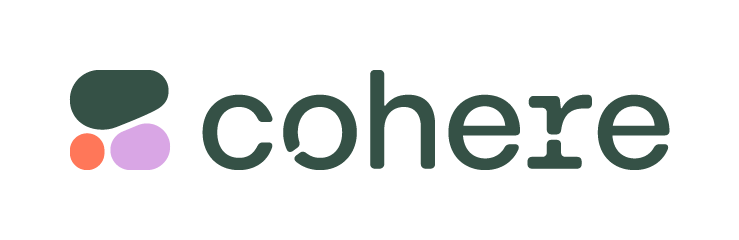

# Notebook Overview

## Motivation 

Tabular data reasoning continues to be an exciting application of Agents, particularly in the financial domain, where multiple reasoning steps may be needed to identify the right answer. For example, a financial analyst working with financial statements may be interested in computing various financial ratios with natural language queries.

Some examples may include:
- ROE (Return on Equity) = Net Income / Shareholder's Equity
- Net Profit Margin = Net Income / Revenue
- Asset Turnover = Revenue / Average Total Assets
- Financial Leverage = Average Total Assets / Shareholder's Equity

Having an Agent which is able to correctly compute these and other ratios would be a great help for any analyst in the field of Finance.

## Objective

In this notebook we explore how to setup a [Cohere Agent](https://docs.cohere.com/docs/multi-step-tool-use) to answer questions over tables in Apple's SEC10K 2020 form. [financial_csv_publication.ipynb](#TODO) already showed how to use langchain to ask questions about your data. This notebook will demonstrate how you can build the same agent using Cohere's native API with langchain python tool. We will also explore how to make your agent more resilient to errors. 

## Table of Contents

- [Setup](#setup)
- [Define Python Tool](#define_python_tool)
- [Create Cohere Agent](#create_cohere_agent)
- [QnA over Single Table](#qna_over_single_table)
- [QnA over Multiple Tables](#qna_over_multiple_tables)
- [Error Resilience](#error_resilience)
    - [Add Viewing Tool](#add_viewing_tool)


<a id="setup"></a>

# Setup

In [32]:
import os
from typing import List

import cohere
import langchain
import langchain_core
import langchain_experimental
import pandas as pd
from langchain.agents import Tool
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_experimental.utilities import PythonREPL

In [ ]:
####################################################################################################
#
# Uncomment if you need to install the following packages
#
####################################################################################################

# !pip install --quiet langchain langchain_experimental cohere --upgrade

In [3]:
# versions
print('cohere version:', cohere.__version__)
print('langchain version:', langchain.__version__)
print('langchain_core version:', langchain_core.__version__)
print('langchain_experimental version:', langchain_experimental.__version__)

cohere version: 5.5.1
langchain version: 0.2.0
langchain_core version: 0.2.0
langchain_experimental version: 0.0.59


### API Key 

In [10]:
COHERE_API_KEY = os.environ["COHERE_API_KEY"]
CHAT_URL= "https://api.cohere.ai/v1/chat"
COHERE_MODEL = 'command-r-plus'
co = cohere.Client(api_key=COHERE_API_KEY)

### Data Loading 

In [5]:
income_statement = pd.read_csv('income_statement.csv')
balance_sheet = pd.read_csv('balance_sheet.csv')

In [51]:
income_statement.head(2)

Unnamed: 0                  index  \
0           0  2017-10-01-2018-09-29   
1           1  2018-09-30-2018-12-29   

   RevenueFromContractWithCustomerExcludingAssessedTax  \
0                                       265595000000     
1                                        84310000000     

   CostOfGoodsAndServicesSold   GrossProfit  ResearchAndDevelopmentExpense  \
0                1.637560e+11  101839000000                   1.423600e+10   
1                         NaN   32031000000                            NaN   

   SellingGeneralAndAdministrativeExpense  OperatingExpenses  \
0                            1.670500e+10       3.094100e+10   
1                                     NaN                NaN   

   OperatingIncomeLoss  NonoperatingIncomeExpense  \
0         7.089800e+10               2.005000e+09   
1                  NaN                        NaN   

   IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest  \
0                                       7.290300e+10                                             
1                                                NaN                                             

   IncomeTaxExpenseBenefit  NetIncomeLoss  EarningsPerShareBasic  \
0             1.337200e+10    59531000000                   3.00   
1                      NaN    19965000000                   1.05   

   EarningsPerShareDiluted  WeightedAverageNumberOfSharesOutstandingBasic  \
0                     2.98                                   1.982151e+10   
1                     1.05                                            NaN   

   WeightedAverageNumberOfDilutedSharesOutstanding  
0                                     2.000044e+10  
1                                              NaN

In [52]:
balance_sheet.head(2)

Unnamed: 0       index  CashAndCashEquivalentsAtCarryingValue  \
0           0  2017-09-30                                    NaN   
1           1  2018-09-29                                    NaN   

   MarketableSecuritiesCurrent  AccountsReceivableNetCurrent  InventoryNet  \
0                          NaN                           NaN           NaN   
1                          NaN                           NaN           NaN   

   NontradeReceivablesCurrent  OtherAssetsCurrent  AssetsCurrent  \
0                         NaN                 NaN            NaN   
1                         NaN                 NaN            NaN   

   MarketableSecuritiesNoncurrent  ...  LongTermDebtNoncurrent  \
0                             NaN  ...                     NaN   
1                             NaN  ...                     NaN   

   OtherLiabilitiesNoncurrent  LiabilitiesNoncurrent  Liabilities  \
0                         NaN                    NaN          NaN   
1                         NaN                    NaN          NaN   

   CommitmentsAndContingencies  CommonStocksIncludingAdditionalPaidInCapital  \
0                          NaN                                           NaN   
1                          NaN                                           NaN   

   RetainedEarningsAccumulatedDeficit  \
0                                 NaN   
1                                 NaN   

   AccumulatedOtherComprehensiveIncomeLossNetOfTax  StockholdersEquity  \
0                                              NaN        134047000000   
1                                              NaN        107147000000   

   LiabilitiesAndStockholdersEquity  
0                               NaN  
1                               NaN  

[2 rows x 30 columns]

<a id="define_python_tool"></a>

# Define Python Tool 

Here we define the python tool using langchain's PythonREPL. We also define `functions_map` that will later be used by the Cohere Agent to correctly map function name to the actual function. Lastly, we define the tools that will be passed in the Cohere API. 


In [121]:
python_repl = PythonREPL()
python_tool = Tool(
    name="python_repl",
    description="Executes python code and returns the result. The code runs in a static sandbox without interactive mode, so print output or save output to a file.",
    func=python_repl.run,
)
python_tool.name = "python_interpreter"

class ToolInput(BaseModel):
    code: str = Field(description="Python code to execute.")
python_tool.args_schema = ToolInput

def run_python_code(code: str) -> dict:
    """
    Function to run given python code
    """
    input_code = ToolInput(code=code)
    return {'python_answer': python_tool.func(input_code.code)}

functions_map = {
    "run_python_code": run_python_code,
}

tools = [
    {
        "name": "run_python_code",
        "description": "given a python code, runs it",
        "parameter_definitions": {
            "code": {
                "description": "executable python code",
                "type": "str",
                "required": True
            }
        }
    },]

<a id="create_cohere_agent"></a>

# Create Cohere Agent 

As [Vanilla_Multi_Step_Tool_Use.ipynb](https://github.com/cohere-ai/notebooks/blob/fbf6c8dad47d7557314e9248a267175c7a6908d8/notebooks/Vanilla_Multi_Step_Tool_Use.ipynb) shows, you have a lot of flexiblity on how you can customize and interact with the cohere agent. Here I am creating a wrapper so that it automatically determines when to stop calling the tools and output final answer. It will run maximum of 15 steps. 

In [108]:
def cohere_agent(
    message: str,
    preamble: str,
    tools: List[dict],
    force_single_step=False,
    verbose: bool = False,
) -> str:
    """
    Function to handle multi-step tool use api.

    Args:
        message (str): The message to send to the Cohere AI model.
        preamble (str): The preamble or context for the conversation.
        tools (list of dict): List of tools to use in the conversation.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        str: The final response from the call.
    """

    counter = 1

    response = co.chat(
        model=COHERE_MODEL,
        message=message,
        preamble=preamble,
        tools=tools,
        force_single_step=force_single_step,
    )

    if verbose:
        print(f"\nrunning 0th step.")
        print(response.text)

    while response.tool_calls:
        tool_results = []

        if verbose:
            print(f"\nrunning {counter}th step.")

        for tool_call in response.tool_calls:
            output = functions_map[tool_call.name](**tool_call.parameters)
            outputs = [output]
            tool_results.append({"call": tool_call, "outputs": outputs})

            if verbose:
                print(
                    f"= running tool {tool_call.name}, with parameters: {tool_call.parameters}"
                )
                print(f"== tool results: {outputs}")

        response = co.chat(
            model=COHERE_MODEL,
            message="",
            chat_history=response.chat_history,
            preamble=preamble,
            tools=tools,
            force_single_step=force_single_step,
            tool_results=tool_results,
        )

        if verbose:
            print(response.text)

            counter += 1

    return response.text


# test
output = cohere_agent("can you use python to answer 1 + 1", None, tools, verbose=True)


running 0th step.
I will use Python to answer this question.

running 1th step.
= running tool run_python_code, with parameters: {'code': 'print(1 + 1)'}
== tool results: [{'python_answer': '2\n'}]
The answer is **2**.


<a id="qna_over_single_table"></a>

# QnA over Single Table 

In the example below, we show how the python tool can be used to load a dataframe and extract information from it. To do this successfully we need to:

1) pass the file name to the preamble so the model knows how to load the dataframe
2) pass a preview of the dataframe in the preamble so the model knows which columns/rows to query

We will ask the following questions given income statement data. 
1. what is the highest value of cost of goods and service?
2. what is the largest gross profit margin?
3. what is the minimum ratio of operating income loss divided by non operating income expense? 

In [109]:
question_dict ={
    'q1': ['what is the highest value of cost of goods and service?',169559000000],
    'q2': ['what is the largest gross profit margin?',0.3836194330595236],
    'q3': ['what is the minimum ratio of operating income loss divided by non operating income expense?',35.360599]
}

In [110]:
preamble = """
You are an expert who answers the user's question. You are working with a pandas dataframe in Python. The name of the dataframe is `income_statement.csv`.
Here is a preview of the dataframe:
{head_df}
""".format(head_df=income_statement.head(3).to_markdown())

print(preamble)


You are an expert who answers the user's question. You are working with a pandas dataframe in Python. The name of the dataframe is `income_statement.csv`.
Here is a preview of the dataframe:
|    |   Unnamed: 0 | index                 |   RevenueFromContractWithCustomerExcludingAssessedTax |   CostOfGoodsAndServicesSold |   GrossProfit |   ResearchAndDevelopmentExpense |   SellingGeneralAndAdministrativeExpense |   OperatingExpenses |   OperatingIncomeLoss |   NonoperatingIncomeExpense |   IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest |   IncomeTaxExpenseBenefit |   NetIncomeLoss |   EarningsPerShareBasic |   EarningsPerShareDiluted |   WeightedAverageNumberOfSharesOutstandingBasic |   WeightedAverageNumberOfDilutedSharesOutstanding |
|---:|-------------:|:----------------------|------------------------------------------------------:|-----------------------------:|--------------:|--------------------------------:|--------------------------

In [111]:
for qsn,val in question_dict.items():
    print(f'question:{qsn}')
    question = val[0]
    answer = val[1]
    output = cohere_agent(question, preamble, tools, verbose=True)
    print(f'GT Answer:{val[1]}')
    print('-'*50)

question:q1

running 0th step.
I will use Python to find the highest value of 'CostOfGoodsAndServicesSold' in the 'income_statement.csv' dataframe.

running 1th step.
= running tool run_python_code, with parameters: {'code': 'import pandas as pd\n\ndf = pd.read_csv(\'income_statement.csv\')\n\n# Find the highest value of \'CostOfGoodsAndServicesSold\'\nhighest_cost = df[\'CostOfGoodsAndServicesSold\'].max()\n\nprint(f"The highest value of \'CostOfGoodsAndServicesSold\' is {highest_cost}")'}
== tool results: [{'python_answer': "The highest value of 'CostOfGoodsAndServicesSold' is 169559000000.0\n"}]
The highest value of 'CostOfGoodsAndServicesSold' is 169559000000.0.
GT Answer:169559000000
--------------------------------------------------
question:q2

running 0th step.
I will write and execute Python code to find the largest gross profit margin.

running 1th step.
= running tool run_python_code, with parameters: {'code': 'import pandas as pd\n\ndf = pd.read_csv(\'income_statement.csv\'

<a id="qna_over_multiple_tables"></a>

# QnA over Multiple Tables 

We now make the task for the Agent more complicated, by asking it a question that answer can be computed only by retrieving relevant information from multiple tables: 

- Q: What is the ratio of the largest stockholders equity to the smallest revenue?

As you will see below, this question can be obtained only by accessing both the balance sheet and the income statement. 



In [112]:
question_dict ={
    'q1': ['what is the ratio of the largest stockholders equity to the smallest revenue'],
}

In [113]:
# get the largest stockholders equity
x = balance_sheet['StockholdersEquity'].astype(float).max()
print(f"The largest stockholders equity value is: {x}")

# get the smallest revenue
y = income_statement['RevenueFromContractWithCustomerExcludingAssessedTax'].astype(float).min()
print(f"The smallest revenue value is: {y}")

# compute the ratio
ratio = x/y
print(f"Their ratio is: {ratio}")

The largest stockholders equity value is: 134047000000.0
The smallest revenue value is: 53809000000.0
Their ratio is: 2.4911631883142227


In [114]:
preamble = """
You are an expert who answers the user's question in complete sentences. You are working with two pandas dataframe in Python. Ensure your output is a string.

Here is a preview of the `income_statement.csv` dataframe:
{table_1}

Here is a preview of the `balance_sheet.csv` dataframe:
{table_2}
""".format(table_1=income_statement.head(3).to_markdown(),table_2=balance_sheet.head(3).to_markdown())


print(preamble)


You are an expert who answers the user's question in complete sentences. You are working with two pandas dataframe in Python. Ensure your output is a string.

Here is a preview of the `income_statement.csv` dataframe:
|    |   Unnamed: 0 | index                 |   RevenueFromContractWithCustomerExcludingAssessedTax |   CostOfGoodsAndServicesSold |   GrossProfit |   ResearchAndDevelopmentExpense |   SellingGeneralAndAdministrativeExpense |   OperatingExpenses |   OperatingIncomeLoss |   NonoperatingIncomeExpense |   IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest |   IncomeTaxExpenseBenefit |   NetIncomeLoss |   EarningsPerShareBasic |   EarningsPerShareDiluted |   WeightedAverageNumberOfSharesOutstandingBasic |   WeightedAverageNumberOfDilutedSharesOutstanding |
|---:|-------------:|:----------------------|------------------------------------------------------:|-----------------------------:|--------------:|--------------------------------:

In [115]:
for qsn,val in question_dict.items():
    print(f'question:{qsn}')
    question = val[0]
    output = cohere_agent(question, preamble, tools, verbose=True)

question:q1

running 0th step.
I will use the provided code to find the ratio of the largest stockholders equity to the smallest revenue.

running 1th step.
= running tool run_python_code, with parameters: {'code': 'import pandas as pd\n\n# Read the CSV files into dataframes\nincome_statement = pd.read_csv(\'income_statement.csv\')\nbalance_sheet = pd.read_csv(\'balance_sheet.csv\')\n\n# Find the smallest revenue\nsmallest_revenue = income_statement[\'RevenueFromContractWithCustomerExcludingAssessedTax\'].min()\n\n# Find the largest stockholders equity\nlargest_stockholders_equity = balance_sheet[\'StockholdersEquity\'].max()\n\n# Calculate the ratio\nratio = largest_stockholders_equity / smallest_revenue\nprint(f"The ratio of the largest stockholders equity to the smallest revenue is {ratio:.2f}")'}
== tool results: [{'python_answer': 'The ratio of the largest stockholders equity to the smallest revenue is 2.49\n'}]
The ratio of the largest stockholders equity to the smallest revenue 

<a id="error_resilience"></a>

# Error Resilience

In the previous example over single table, the model successfully answered your questions. However, the model may not always have access to the preview of the data. You will see that when we remove the preview from the preamble, the model is run into an error and not produce the answer. We will solve this problem with two different ways: 

1. Asking the model to keep trying until it fixes the issue. 
2. Giving the model another tool to view the data and telling it to preview the data before writing code. 

You will see that the second method is able to come to the answer with fewer steps. 


In [116]:
preamble = """
You are an expert who answers the user's question. You are working with a pandas dataframe in Python. The name of the dataframe is `income_statement.csv`.
"""

question1 = "what is the highest value of cost of goods and service?"

output = cohere_agent(question1, preamble, tools, verbose=True)


running 0th step.
I will use Python to find the highest value of 'Cost of Goods and Service' in the 'income_statement.csv' file.

running 1th step.
= running tool run_python_code, with parameters: {'code': 'import pandas as pd\n\ndf = pd.read_csv(\'income_statement.csv\')\n\n# Find the highest value of \'Cost of Goods and Service\'\nhighest_cost = df[\'Cost of Goods and Service\'].max()\n\nprint(f"The highest value of \'Cost of Goods and Service\' is: {highest_cost}")'}
== tool results: [{'python_answer': "KeyError('Cost of Goods and Service')"}]
Sorry, there is no column named 'Cost of Goods and Service' in the 'income_statement.csv' file.


As you see above, the model failed to execute because it assumed certain column names but they turned out to be wrong. One simple fix is to tell the model to continue to solve the problem in the face of error. 

In [123]:
preamble = """
You are an expert who answers the user's question. You are working with a pandas dataframe in Python. The name of the dataframe is `income_statement.csv`.
If you run into error, keep trying until you fix it. You may need to view the data to understand the error.
"""

question1 = "what is the highest value of cost of goods and service?"

output = cohere_agent(question1, preamble, tools, verbose=True)


running 0th step.
I will use Python to find the highest value of cost of goods and service.

running 1th step.
= running tool run_python_code, with parameters: {'code': 'import pandas as pd\n\ndf = pd.read_csv(\'income_statement.csv\')\n\n# Find the highest value of \'Cost of Goods and Services\'\nhighest_cost = df[\'Cost of Goods and Services\'].max()\n\nprint(f"The highest value of \'Cost of Goods and Services\' is: {highest_cost}")'}
== tool results: [{'python_answer': "KeyError('Cost of Goods and Services')"}]
I encountered an error. I will now view the data to understand the error.

running 2th step.
= running tool run_python_code, with parameters: {'code': "import pandas as pd\n\ndf = pd.read_csv('income_statement.csv')\n\nprint(df.columns)"}
== tool results: [{'python_answer': "Index(['Unnamed: 0', 'index',\n       'RevenueFromContractWithCustomerExcludingAssessedTax',\n       'CostOfGoodsAndServicesSold', 'GrossProfit',\n       'ResearchAndDevelopmentExpense',\n       'Selling

<a id="add_viewing_tool"></a>

### Add Viewing Tool 

What if we directly give the model the ability to view the data as a tool so that it can explicitly use it instead of indirectly figuring it out? 

In [119]:
def view_csv_data(path: str) -> dict:
    """
    Function to view the head, tail and shape of a given csv file.
    """
    df = pd.read_csv(path)

    return {
        "head": df.head().to_string(),
        "tail": df.tail().to_string(),
        "shape": str(df.shape),
    }

functions_map = {
    "run_python_code": run_python_code,
    "view_csv_data": view_csv_data
}

tools = [
    {
        "name": "run_python_code",
        "description": "given a python code, runs it",
        "parameter_definitions": {
            "code": {
                "description": "executable python code",
                "type": "str",
                "required": True
            }
        }
    },
    {
        "name": "view_csv_data",
        "description": "give path to csv data and get head, tail and shape of the data",
        "parameter_definitions": {
            "path": {
                "description": "path to csv",
                "type": "str",
                "required": True
            }
        }
    },
]

In [120]:
preamble = """
You are an expert who answers the user's question. You are working with a pandas dataframe in Python. The name of the dataframe is `income_statement.csv`.
Always view the data first to write flawless code.
"""

question1 = "what is the highest value of cost of goods and service?"

output = cohere_agent(question1, preamble, tools, verbose=True)


running 0th step.
I will first view the data and then write and execute Python code to find the highest value of cost of goods and service.

running 1th step.
= running tool view_csv_data, with parameters: {'path': 'income_statement.csv'}
== tool results: [{'head': '   Unnamed: 0                  index  RevenueFromContractWithCustomerExcludingAssessedTax  CostOfGoodsAndServicesSold   GrossProfit  ResearchAndDevelopmentExpense  SellingGeneralAndAdministrativeExpense  OperatingExpenses  OperatingIncomeLoss  NonoperatingIncomeExpense  IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest  IncomeTaxExpenseBenefit  NetIncomeLoss  EarningsPerShareBasic  EarningsPerShareDiluted  WeightedAverageNumberOfSharesOutstandingBasic  WeightedAverageNumberOfDilutedSharesOutstanding\n0           0  2017-10-01-2018-09-29                                         265595000000                1.637560e+11  101839000000                   1.423600e+10                      

By being prescriptive, we were able to cut down a step and get to the answer faster. 